# Notebook for calculating the experience score for the participants and set up the meta data in a useful format

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
df_questionnaire = pd.read_excel("./data/Questionnaire.xlsx", sheet_name="Experience")
# transpose the dataframe
df_questionnaire = df_questionnaire.transpose()
# use first row as column names
df_questionnaire.columns = df_questionnaire.iloc[0]
#delete first row
df_questionnaire = df_questionnaire.drop(df_questionnaire.index[0])
#drop row where years of programming is missing
df_questionnaire = df_questionnaire.dropna(subset=["yearsAtWork"])
#change all NaN to 0
df_questionnaire = df_questionnaire.fillna(0)

# drop row with "Participant" being 9
df_questionnaire = df_questionnaire.drop(9)

df_questionnaire["yearsOfProgramming"] = df_questionnaire["yearsOfProgramming"].astype(float)
df_questionnaire["yearsOfJava"] = df_questionnaire["yearsOfJava"].astype(float)

## Check Correlation Effects

In [3]:
# calculate the pearson correlation between the years of programming and the years of java
corr = df_questionnaire.corr(method="pearson")
corr.values[[np.arange(corr.shape[0])] * 2] = 0
corr

<ipython-input-3-e8b318895153>:3: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  corr.values[[np.arange(corr.shape[0])] * 2] = 0


Participant,yearsOfProgramming,yearsOfProfessionalProgramming,yearsOfJava,logicalExperience,functionalExperience,imperativExperience,objectExperience,comparedToStudent,comparedToProfessional
Participant,,,,,,,,,
yearsOfProgramming,0.000000,0.912879,0.834671,0.196881,0.277054,0.298009,0.405389,-0.155277,0.222305
yearsOfProfessionalProgramming,0.912879,0.000000,0.755738,0.162842,0.153438,0.211286,0.451542,-0.067585,0.287723
yearsOfJava,0.834671,0.755738,0.000000,0.107167,0.313488,0.186688,0.348047,-0.123541,0.267995
logicalExperience,0.196881,0.162842,0.107167,0.000000,0.438185,0.364237,0.112319,0.161150,0.299794
functionalExperience,0.277054,0.153438,0.313488,0.438185,0.000000,0.311776,0.099272,0.019113,0.308248
imperativExperience,0.298009,0.211286,0.186688,0.364237,0.311776,0.000000,0.393788,-0.083585,0.211158
objectExperience,0.405389,0.451542,0.348047,0.112319,0.099272,0.393788,0.000000,0.078476,0.393626
comparedToStudent,-0.155277,-0.067585,-0.123541,0.161150,0.019113,-0.083585,0.078476,0.000000,0.496090
comparedToProfessional,0.222305,0.287723,0.267995,0.299794,0.308248,0.211158,0.393626,0.496090,0.000000


In [4]:
df_behavioral = pd.read_csv("./data/filteredData/filtered_data.csv")
# drop unnamed column
df_behavioral = df_behavioral[df_behavioral["Subpart"] == "Code"]
df_behavioral["Behavioral"] = df_behavioral["Behavioral"].apply(lambda x: "Right" if x == "Right" else "Wrong")
df_behavioral["Duration"] = df_behavioral["EndTime"] - df_behavioral["StartTime"]

In [5]:
lowest = df_behavioral["Duration"].quantile(0.05)
highest = df_behavioral["Duration"].quantile(0.95)

# kick out all rows where the duration is not in the 5% quantile range
df_behavioral["IsOutlier"] = True
df_behavioral.loc[((df_behavioral["Duration"] > lowest) & (df_behavioral["Duration"] < highest))
                  | (df_behavioral["Duration"] <= lowest) & (
                          df_behavioral["Behavioral"] == "Right"), "IsOutlier"] = False

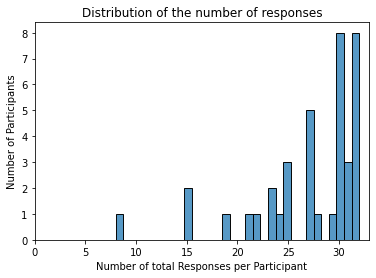

In [6]:
df_tmp = df_behavioral.groupby("Participant")\
    .apply(lambda df: len(df[df["IsOutlier"] == False]))\
    .to_frame("Duration")

# create a histogram of the duration of the snippets
g = sns.histplot(df_tmp["Duration"], bins=32, label="Participants")
g.set_xlabel("Number of total Responses per Participant")
g.set_ylabel("Number of Participants")
g.set_title("Distribution of the number of responses")
g.set_xlim(0, 33);

In [7]:
df_behavioral = df_behavioral.set_index("Participant", drop=True)

In [8]:
df_behavioral["SumCorrect"] = df_behavioral.groupby("Participant")\
    .apply(lambda df: df[df["IsOutlier"] == False])\
    .groupby("Participant")\
    .apply(lambda df: len(df[df["Behavioral"] == "Right"]))

df_behavioral["Total"] = df_behavioral.groupby("Participant")\
    .apply(lambda df: len(df[df["IsOutlier"] == False]))

df_behavioral["SumDurationInMinutes"] = pd.read_csv("./data/filteredData/filtered_data.csv")\
    .groupby("Participant")\
    .apply(lambda df: df["EndTime"].array[-1] - df["StartTime"].array[0] + 30.0)

df_behavioral["SkillScore"] = df_behavioral["SumCorrect"] / (df_behavioral["SumDurationInMinutes"] / 60.0)

In [9]:
df_behavioral[~df_behavioral.index.duplicated(keep='first')]["SumDurationInMinutes"]

Participant
1     4013.279641
2     4144.059902
3     2535.910764
4     3985.479718
5     3863.480571
6     4018.194175
7     4021.702411
10    3454.733665
11    4070.273653
12    4104.600060
13    4176.217116
14    4202.448496
18    4279.459799
22    4247.962996
24    3984.307315
25    4331.132959
28    4140.462543
35    2496.782760
36    3764.501752
37    4298.087901
38    3227.601457
41    4223.502276
42    4658.015541
46    5120.639623
49    4239.946382
50    4157.481758
55    4152.392179
58    4272.951816
59    4226.120565
60    4364.798324
61    4344.790617
62    4268.889176
63    4173.298634
66    3049.293793
67    4185.514052
68    2659.274382
70    4436.403413
71    3473.124016
Name: SumDurationInMinutes, dtype: float64

In [10]:
df_skill = df_behavioral[~df_behavioral.index.duplicated(keep='first')]
df_skill = df_skill.drop(columns=["Algorithm", "Behavioral", "Duration", "IsOutlier"])
df_skill

,Subpart,StartTime,EndTime,Eyetracking,EEG,SumCorrect,Total,SumDurationInMinutes,SkillScore
Participant,,,,,,,,,
1,Code,0.0,12.390280,./data/filteredData/Participant01/IsPrimecode_...,./data/filteredData/Participant01/IsPrimecode_...,22,32,4013.279641,0.328908
2,Code,0.0,40.635115,./data/filteredData/Participant02/HeightOfTree...,./data/filteredData/Participant02/HeightOfTree...,26,32,4144.059902,0.376442
3,Code,0.0,92.877823,./data/filteredData/Participant03/SiebDesErato...,./data/filteredData/Participant03/SiebDesErato...,13,15,2535.910764,0.307582
4,Code,0.0,94.990470,./data/filteredData/Participant04/HIndexcode_e...,./data/filteredData/Participant04/HIndexcode_e...,28,32,3985.479718,0.421530
5,Code,0.0,109.680191,./data/filteredData/Participant05/SiebDesErato...,./data/filteredData/Participant05/SiebDesErato...,20,32,3863.480571,0.310601
6,Code,0.0,28.998734,./data/filteredData/Participant06/RemoveDouble...,./data/filteredData/Participant06/RemoveDouble...,21,28,4018.194175,0.313574
7,Code,0.0,28.138863,./data/filteredData/Participant07/InsertSortco...,./data/filteredData/Participant07/InsertSortco...,28,31,4021.702411,0.417734
10,Code,0.0,31.310999,./data/filteredData/Participant10/ContainsSubs...,./data/filteredData/Participant10/ContainsSubs...,20,30,3454.733665,0.347349
11,Code,0.0,51.498158,./data/filteredData/Participant11/DumpSortingc...,./data/filteredData/Participant11/DumpSortingc...,12,19,4070.273653,0.176892


In [11]:
df_skill.describe()

,StartTime,EndTime,SumCorrect,Total,SumDurationInMinutes,SkillScore
count,38.0,38.000000,38.000000,38.000000,38.000000,38.000000
mean,0.0,60.225218,20.368421,27.000000,3983.345163,0.316291
std,0.0,52.490600,5.508819,5.579887,554.021148,0.107285
min,0.0,10.538237,7.000000,8.000000,2496.782760,0.082021
25%,0.0,24.546640,17.000000,25.000000,3984.600416,0.248514
50%,0.0,38.343863,21.000000,29.500000,4154.936968,0.313055
75%,0.0,80.916655,24.000000,31.000000,4263.657631,0.373977
max,0.0,180.050434,29.000000,32.000000,5120.639623,0.648835


Text(0.5, 1.0, 'Correct answers per minute Distribution')

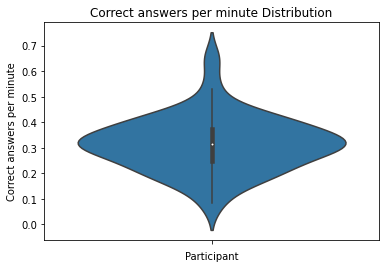

In [12]:
g = sns.violinplot(y="SkillScore", data=df_skill, inner="box")
g.set_xlabel("Participant")
g.set_ylabel("Correct answers per minute")
g.set_title("Correct answers per minute Distribution")

In [13]:
# check if correct_per_time is normal distributed with shapiro-wilk test
import scipy

scipy.stats.shapiro(df_skill["SkillScore"])

ShapiroResult(statistic=0.9649207592010498, pvalue=0.273220032453537)

In [14]:
df_behavioral.to_csv("./data/filteredData/filtered_data.csv")